In [1]:
### basic libraries
import os
import itertools
from datetime import datetime
from json import dumps
import pandas as pd 
import numpy as np

### carto libraries
import shapefile ### not necessary ?
import geopandas as gp
#from shapely.geometry import Polygon
from shapely.geometry import shape

### for plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams["figure.figsize"] = (10.0, 10.0)
#plt.style.use("bmh")
plt.style.use("ggplot")

from app.scripts.topojson import topojson

from pyproj import Proj, transform ### not necessary ?

crs_lambert93 = 2154
crs_WSG84     = 4326
inCRS  = 'epsg:%s' %(crs_lambert93)
outCRS = 'epsg:%s' %(crs_WSG84)
inProj  = Proj(init=inCRS)  # proj in  : Lambert 93
outProj = Proj(init=outCRS) # proj out : WSG 84

### TO DO : find topojson libraries to reduce output file size


In [2]:
print (plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [3]:
### basic folders addresses and names
cwd = os.getcwd()

data_folder      = "app/static/data"
carto_folder     = "carto"
_web             = "_web"
carto_web_folder = carto_folder + _web

carto_path     = os.path.join(cwd, data_folder, carto_folder)
carto_web_path = os.path.join(cwd, data_folder, carto_web_folder)

print "-- cwd :"            , cwd
print "-- carto path     : ", carto_path
print "-- carto_web path : ", carto_web_path


-- cwd : /Users/jpy/Dropbox/_FLASK/concours_pesticides
-- carto path     :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto
-- carto_web path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto_web


In [4]:
### basic pandas tools

idx = pd.IndexSlice

def checkDTypes (df) :
    # check data type
    
    for index in df.index.names :
        print "---- index : ", index

    for col in df.columns :
        #label = col.values
        dtype = df[col].dtype
        
        print "---- dtypes col : ", col, "/", dtype
        

In [5]:
# cf : https://pypi.python.org/pypi/pyshp
# cf : http://gis.stackexchange.com/questions/183795/how-do-i-select-shapefiles-to-be-converted-to-geojson-in-folder-with-multiple-sh
# cf : https://github.com/mlaloux/Python-geo_interface-applications/blob/master/PyShp_geointerface.py

# cf : https://glenbambrick.com/tag/pyshp/
# cf : https://glenbambrick.com/2016/01/24/reproject-shapefile/

In [6]:
### reading/writing - converting shp files to geojson
    
def geofile_path(filename, extension):
    path = os.path.join(carto_path , filename + extension )
    print "-- file path : ", path
    return path


In [7]:
### SHP and GEOJSON files 
_shp     = ".shp"
_json    = ".json"
_geojson = ".geojson"
_copy    = "_copy"

## .shp source for Masses d'eau
water_shp_fname    = "PolygMasseDEauSouterraine"

## add departements .geojson for other future datas than water (f.i. agriculture stats / src : Etalab)
# https://github.com/gregoiredavid/france-geojson

admin_regions      = "regions"
admin_regions_2015 = "regions_2015"
admin_departements = "departements"
admin_communes     = "communes"


In [8]:
### DEPRECATED : read .shp with shapefile
'''
def readSHP(filename):  
    # generator 
    reader = shapefile.Reader( root_carto_folder+ filename + _shp )  
    fields = reader.fields[1:]  
    field_names = [field[0] for field in fields]  
    for sr in reader.shapeRecords():  
        geom = sr.shape.__geo_interface__  
        atr = dict(zip(field_names, sr.record))  
        yield dict(geometry=geom,properties=atr)    
'''
'''
def readSHP(filename) :
    
    # read the shapefile
    reader = shapefile.Reader( geofile_path( water_shp_fname, _shp ) )
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]

    buffer = []
    for sr in reader.shapeRecords():
       atr = dict(zip(field_names, sr.record))
       geom = sr.shape.__geo_interface__
       buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

    # write the GeoJSON file (copy)
    geojson = open( os.path.join( carto_path, filename + _copy + _json), "w")
    geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
    geojson.close()
'''

print    

In [9]:
# return X,Y from centroid point

def getXY (centroidPoint):
    #print centroidPoint
    px = centroidPoint.x
    py = centroidPoint.y
    return (px, py)


In [10]:
### options for gdf.read_file()
#import fiona; help(fiona.open)

### options for gdf.to_file()
#import fiona; fiona.supported_drivers

In [11]:
### read departements / regions geojson with geopandas

#gdf_dpts = gp.GeoDataFrame.from_file( geofile_path( admin_departements, _geojson ) )
gdf_dpts         = gp.read_file( geofile_path( admin_departements, _geojson ) )
gdf_regions      = gp.read_file( geofile_path( admin_regions, _geojson ) )
gdf_regions_2015 = gp.read_file( geofile_path( admin_regions_2015, _geojson ) )

print gdf_dpts.crs

# change projection crs (greedy)
# http://geopandas.org/projections.html

#gdf_dpts = gdf_dpts.to_crs(epsg=crs_WSG84)
#gdf_dpts = gdf_dpts.to_crs({'init': 'epsg:%s' %(crs_lambert93)} )
gdf_dpts         = gdf_dpts.to_crs(        epsg=crs_lambert93)
gdf_regions      = gdf_regions.to_crs(     epsg=crs_lambert93)
gdf_regions_2015 = gdf_regions_2015.to_crs(epsg=crs_lambert93)

print gdf_dpts.crs


-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/departements.geojson
-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/regions.geojson
-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/regions_2015.geojson
{'init': u'epsg:4326'}
{'init': 'epsg:2154', 'no_defs': True}


In [12]:
for gdf in [gdf_dpts, gdf_regions, gdf_regions_2015 ] :
    gdf["area"]     = gdf["geometry"].area
    gdf["centroid"] = gdf["geometry"].centroid


In [13]:
gdf_dpts.head(1)

,code,geometry,nom,area,centroid
0,01,"POLYGON ((919194.9670950606 6541469.955321653,...",Ain,5.773974e+09,POINT (881425.4003322608 6558215.497951342)


In [14]:
'''
Colormap White is not recognized. Possible values are: 
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, 
CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, 
Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, 
PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, 
RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, 
Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, 
YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, 
binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, 
copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, 
gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, 
hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, 
nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, 
rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, 
terrain, terrain_r, viridis, viridis_r, winter, winter_r
'''

cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]


# cf : https://gist.github.com/jakevdp/91077b0cae40f8f8244a   
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


#plot_reg        = gdf_regions.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
#plot_reg_2015   = gdf_regions_2015.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
#plot_dpt        = gdf_dpts.plot(ax=plot_reg_2015, cmap=None, alpha=0, edgecolor='White', linewidth='0.1')


In [15]:
############################################
###########################################
### CARTO MASSES D'EAU 
###########################################
###########################################


In [16]:
"""
### cf : http://www.sandre.eaufrance.fr/urn.php?urn=urn:sandre:dictionnaire:MDO::entite:MasseDEau:ressource:latest:::html
Le code de la masse d'eau est structuré de la manière suivante :
Code du bassin (district au sens de la dce) + 
Code du type (
    "R" pour rivière, 
    "L" pour plan d'eau, 
    "T" pour transition, 
    "C" pour cotière, 
    "G" pour masse d'eau souterraine) 
    + Incrément.
    

"""
print 

In [17]:
### read .shp waters with geopandas (greedy) <-- 0:01:22

start_read_time = datetime.now()
print "-- start reading shp file / gdf_waters_raw --> %s " %(start_read_time)

shp_encoding = "utf-8"   ### doesn't work
shp_encoding = "latin-1" ### not sure

crs_source = crs_lambert93
#crs_source = "lcc" ### not sure
## {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84','no_defs': True}


### read SHP file
#gdf_waters_raw = gp.read_file( geofile_path( water_shp_fname, _shp ), crs=crs_source, encoding=shp_encoding )
gdf_waters_raw = gp.GeoDataFrame.from_file( geofile_path( water_shp_fname, _shp ) )

# set and sort index
gdf_waters_raw.set_index(["CdBassinDC", "CdMasseDEa"], inplace=True)
gdf_waters_raw.sortlevel(inplace=True) 

finish_read_delta_time = datetime.now() - start_read_time
print "-- finish reading shp file / gdf_waters_raw --> %s " %(finish_read_delta_time)


-- start reading shp file / gdf_waters_raw --> 2016-12-31 00:07:21.237630 
-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/PolygMasseDEauSouterraine.shp
-- finish reading shp file / gdf_waters_raw --> 0:02:04.848848 


In [18]:
gdf_waters_raw.shape


(1103, 24)

In [19]:
#### WORK ON gdf_waters FROM NOW (COPY OF : gdf_waters_raw)

gdf_waters = gdf_waters_raw.copy()


In [20]:
# check crs
print gdf_waters.crs


{u'lon_0': 3, u'ellps': u'GRS80', u'y_0': 6600000, u'no_defs': True, u'proj': u'lcc', u'x_0': 700000, u'units': u'm', u'lat_2': 44, u'lat_1': 49, u'lat_0': 46.5}


In [21]:
def colToDate(df, list_col_names):
    # change to date format
    
    for col in list_col_names :
        df.loc[:, col] = pd.to_datetime( df.loc[:, col], infer_datetime_format=True)
    
    return df

# change date format
gdf_waters = colToDate( gdf_waters, ["DateCreati", "DateMajMas"] )


In [22]:
gdf_waters["area"]     = gdf_waters["geometry"].area
gdf_waters["centroid"] = gdf_waters["geometry"].centroid


In [23]:
gdf_waters['CdBassinDC'] = gdf_waters.index.get_level_values('CdBassinDC') 
gdf_waters['CdMasseDEa'] = gdf_waters.index.get_level_values('CdMasseDEa') 


In [24]:
gdf_waters.head(2)


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001              13    FRAG001   00000002       None 2004-12-31   
           AG001              13    FRAG001   00000001       None 2004-12-31   

                      DateMajMas FrangeLitt Karstique    LatMasseDE  \
CdBassinDC CdMasseDEa                                                 
A          AG001      2013-12-18          N         N  7.069081e+06   
           AG001      2013-12-18          N         N  7.069081e+06   

                          LonMasseDE     ...     SurfaceAff SurfaceSsC  \
CdBassinDC CdMasseDEa                    ...                             
A          AG001       639573.042158     ...          868.2       82.4   
           AG001       639573.042158     ...          868.2       82.4   

                      SurfaceTot  SystemeRef TypeMasseD  \
CdBassinDC CdMasseDEa                                     
A          AG001           950.6          26         DS   
           AG001           950.6          26         DS   

                                                                geometry  \
CdBassinDC CdMasseDEa                                                      
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...   
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...   

                               area  \
CdBassinDC CdMasseDEa                 
A          AG001       8.237526e+07   
           AG001       8.681770e+08   

                                                          centroid  \
CdBassinDC CdMasseDEa                                                
A          AG001       POINT (633559.5781241878 7082551.460281919)   
           AG001       POINT (628581.5922041651 7071783.175484098)   

                       CdBassinDC  CdMasseDEa  
CdBassinDC CdMasseDEa                          
A          AG001                A       AG001  
           AG001                A       AG001  

[2 rows x 28 columns]

In [25]:
# correct / debug unvalid geometries
# ---> 00:06:00

def buffer_geom(row):
    
    debug             = True
    buffer_on_unvalid = False ### False == apply on all .shp
    
    geom              = row["geometry"]
    is_valid          = geom.is_valid
    buffer_value      = 0
    
    
    if buffer_on_unvalid == True :
        
        if is_valid == False :

            if debug == True :
                print "-- unvalid geom for CdEuMasseD : %s / CdPolygMas : %s " %(row["CdEuMasseD"], row["CdPolygMas"])

            geom = geom.buffer(buffer_value)

        else : 
            pass
    
    else : 

        geom = geom.buffer(buffer_value)

    return geom


start_buffer_time = datetime.now()                                                               

gdf_waters["geometry"] = gdf_waters.apply(buffer_geom, axis=1)

'''
TopologyException: found non-noded intersection 
LINESTRING (606678 6.68873e+06, 606674 6.68873e+06) 
and 
LINESTRING (606674 6.68873e+06, 606678 6.68873e+06) 
at 
606674.05562397465 6688731.6787636271
'''

finish_buffer_delta_time = datetime.now() - start_read_time
print "-- finish reading shp file --> %s " %(finish_buffer_delta_time)




Ring Self-intersection at or near point 803916.86371147633 6957802.5956156328
Ring Self-intersection at or near point 826425.25400499254 6962164.8597894236
Ring Self-intersection at or near point 918527.7121681273 6850067.7743136622
Ring Self-intersection at or near point 1055789.7500000075 6316287.5
Ring Self-intersection at or near point 908897.875 6751941.5000000186
Ring Self-intersection at or near point 895876.25000002235 6739071.5000000261
Ring Self-intersection at or near point 930191.12503334135 6578068.5000333339
Ring Self-intersection at or near point 865806.93750000745 6680038.0001000091
Ring Self-intersection at or near point 684911.37510001659 6155322.5001000017
Ring Self-intersection at or near point 686086.62510000169 6157375.0001000054
Ring Self-intersection at or near point 844683.18750000745 6443596.0001000091
Ring Self-intersection at or near point 851261.12510002404 6482992.0001000054
Ring Self-intersection at or near point 892951.2501000315 6468589.5001000129
Ring 

-- finish reading shp file --> 0:04:30.872003 


In [26]:
#gdf_waters["geom_valid"] = gdf_waters["geometry"].is_valid

In [27]:
### test not valid geoms 
#not_valid_geoms = gdf_waters.loc[ gdf_waters["geom_valid"] == False ]
#print not_valid_geoms.shape
#not_valid_geoms.head(3)
#not_valid_geoms.plot()

In [28]:
### test not valid geom
#notvalid_a  = gdf_waters.loc[ idx[:, "B1G018"], :].copy()
#notvalid_b = notvalid_a.loc[ notvalid_a["geom_valid"] == False ]
#notvalid_b.plot()
#notvalid_b["geometry"] = notvalid_b["geometry"].buffer(0.0)
#print notvalid_b["geometry"].is_valid

In [29]:
print gdf_waters.shape

(1103, 28)


In [30]:
#checkDTypes(gdf_waters) 


In [31]:
#print list(gdf_waters.index.get_level_values("CdBassinDC").unique())

In [32]:
#print list(gdf_waters.index.get_level_values("CdMasseDEa").unique())[:20], "..."

In [33]:
#print list(gdf_waters.columns.values)

In [34]:
#gdf_waters.index

In [36]:
### list of unique values MdE_cd for index "CdMasseDEa"

Bassins_cd_dict = {"lev_index" : 1, "cd_list" : list( gdf_waters.index.get_level_values("CdBassinDC").unique() ) }
MdEs_cd_dict    = {"lev_index" : 2, "cd_list" : list( gdf_waters.index.get_level_values("CdMasseDEa").unique() ) }

print "lev_index : %s - cd_list : %s" %(Bassins_cd_dict["lev_index"]     , Bassins_cd_dict["cd_list"])
print "lev_index : %s - cd_list : ... %s ..." %(MdEs_cd_dict["lev_index"], MdEs_cd_dict["cd_list"][-20:])
print 

### dictionnaries sublevels
Bassins_ME_dict = {}
for bassin in Bassins_cd_dict["cd_list"] :
    sub_ME = [ ME for ME in MdEs_cd_dict["cd_list"] if ( ME.startswith(bassin) ) ]
    Bassins_ME_dict[bassin] = sub_ME
    print " %s : count %s ME" %(bassin, len(sub_ME) )

print

test_uplevel = "G"
print " Bassins_ME_dict['%s'] : " %(test_uplevel), Bassins_ME_dict[test_uplevel]
print 

### reverse Bassins_ME_dict
ME_Bassins_dict ={}
for bassin, ME_list in Bassins_ME_dict.iteritems():
    for ME in ME_list :
        ME_Bassins_dict[ME] = bassin
    
test_sublevel = "AG001"
print " ME_Bassins_dict['%s'] : " %(test_sublevel), ME_Bassins_dict[test_sublevel]


 lev_index : 1 - cd_list : [u'A', u'B1', u'B2', u'C', u'D', u'E', u'F', u'G', u'H']
lev_index : 2 - cd_list : ... [u'HG301', u'HG302', u'HG303', u'HG304', u'HG305', u'HG306', u'HG307', u'HG308', u'HG309', u'HG310', u'HG401', u'HG402', u'HG501', u'HG502', u'HG503', u'HG504', u'HG505', u'HG506', u'HG507', u'HG508'] ...

 A : count 16 ME
 B1 : count 11 ME
 B2 : count 2 ME
 C : count 15 ME
 D : count 239 ME
 E : count 15 ME
 F : count 105 ME
 G : count 143 ME
 H : count 53 ME

 Bassins_ME_dict['G'] :  [u'GG001', u'GG002', u'GG003', u'GG004', u'GG005', u'GG006', u'GG007', u'GG008', u'GG009', u'GG010', u'GG011', u'GG012', u'GG013', u'GG014', u'GG015', u'GG016', u'GG017', u'GG018', u'GG019', u'GG020', u'GG021', u'GG022', u'GG023', u'GG024', u'GG025', u'GG026', u'GG027', u'GG028', u'GG029', u'GG030', u'GG031', u'GG032', u'GG033', u'GG034', u'GG035', u'GG036', u'GG037', u'GG038', u'GG039', u'GG040', u'GG041', u'GG042', u'GG043', u'GG044', u'GG045', u'GG046', u'GG047', u'GG048', u'GG049', u'GG05

In [37]:
### test loc

gdf_waters.loc[ idx[ "G", : ], "MasseDEauA": ].shape
#gdf_waters.loc[ idx[ "A", : ], "MasseDEauA":"TypeMasseD" ].head()

(307, 18)

In [70]:
listA = ["AG001", "AG002", "AG003"]
listB = ["AG002"]
listC = [i for i in listA if i not in listB]
print listC

['AG001', 'AG003']


In [38]:
gdf_waters_copy = gdf_waters.copy()

#gdf_waters_copy.loc[ idx["G", "GG067"] ] = gdf_waters_copy.loc[ idx["G", "GG067"] ]["geometry"].simplify(200, preserve_topology=False)
#gdf_waters_copy.loc[ idx["G", "GG067"] ] = gdf_waters_copy.loc[ idx["G", "GG067"] ]["geometry"].buffer(0)

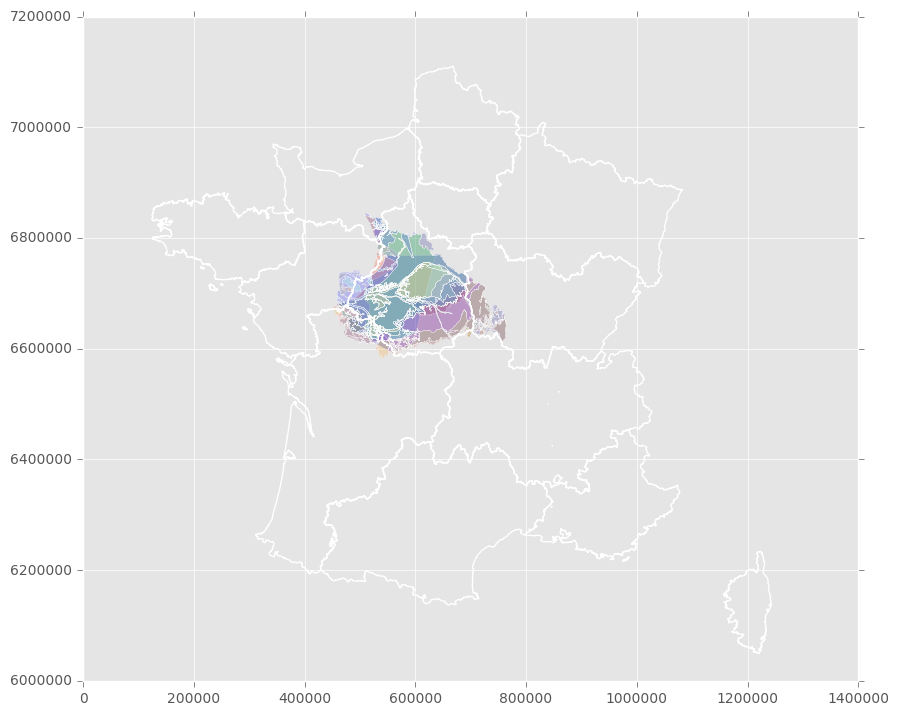

In [71]:
### !!!! BASTARDS !!!! #####
### ------------------ #####

#plot_reg        = gdf_regions.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
#plot_reg_2015   = gdf_regions_2015.plot(cmap=discrete_cmap(13, "Dark2"), alpha=1, edgecolor='White' )
#plot_dpt        = gdf_dpts.plot(ax=plot_reg_2015, cmap=None, alpha=0, edgecolor='White', linewidth='0.1')

bastards = ["GG067", "GG073", "GG130", "GG131"]

idx = pd.IndexSlice
bastard = gdf_waters.loc[ idx[ : , bastards ], : ]

plot_bastard  = bastard.plot(edgecolor="White", alpha=0.2, linewidth='0.1')
plot_reg_2015 = gdf_regions_2015.plot(ax=plot_bastard, cmap=None, alpha=0, edgecolor='White', linewidth='1' )

In [55]:
print bastard.iloc[0]

CdEcoregio                                                   13
CdEuMasseD                                              FRGG137
CdPolygMas                                             00000972
Commentair    Ancien libellÃ© de masse d'eau: Alluvions Loir...
DateCreati                                  2004-12-31 00:00:00
DateMajMas                                  2013-12-18 00:00:00
FrangeLitt                                                    N
Karstique                                                     N
LatMasseDE                                          6.68698e+06
LonMasseDE                                               478979
MasseDEauA                                                    N
MasseDEauT                                                    N
NatureEcou                                                    1
Niveau                                                        1
NomMasseDE           Alluvions de la Loire moyenne aprÃ¨s Blois
PrecSupMas                              

In [ ]:
## test loc on geometry

#test_geom = gdf_waters.loc["A","AG001"]["geometry"]
#test_geom

In [ ]:
### test loc slice 2 dimensions

#gdf_waters.head(50).loc[ idx[:,"AG001"], idx["MasseDEauA":]]


In [ ]:
### test if NaN in CdMasseDEa

#for cd in list(gdf_waters.index.get_level_values("CdMasseDEa").unique()) :
#    if len(cd)<5 :
#        print cd

In [ ]:
#gdf_waters.info(memory_usage="deep")

In [ ]:
#gdf_waters.memory_usage().sum()

In [ ]:

####################################################
### SIMPLIFY BY UNION  - WARNING GREEDY 5 MIN APPROX.
####################################################


In [ ]:
# work on a copy of original gdf_waters
gdf_waters_copy = gdf_waters.copy()


In [ ]:
### set test slice
'''
 A  : count 16 ME
 B1 : count 11 ME
 B2 : count 2 ME
 C  : count 15 ME
 D  : count 239 ME <-- 
 E  : count 15 ME
 F  : count 105 ME <-- 
 G  : count 143 ME <-- !!!
 H  : count 53 ME  <-- not that fast
'''

idx = pd.IndexSlice

level_1   = "G"
level_2   = "AG001"

slice_gdf_lev1 = idx[ level_1 , : ]
slice_gdf_lev2 = idx[ : , level_2 ]

slice_idx = slice_gdf_lev1

print slice_idx

#gdf_waters.loc[ slice_gdf_lev1 , : ]["geometry"]


In [ ]:
### empty structured GDF 
def empty_GDF(gdf_in, level_index):
    
    tuples  = []
    
    if level_index == 1 :
        cd_list = Bassins_cd_dict["cd_list"]
        _all    = "XXXXX"
        for bassin in cd_list : 
            tuple_bassin = ( bassin, bassin + _all )
            tuples.append(tuple_bassin)
                
    elif level_index == 2 :
        cd_list = MdEs_cd_dict["cd_list"]
        for ME in cd_list : 
            tuple_ME = ( ME_Bassins_dict[ME], ME ) 
            tuples.append(tuple_ME)
            
    ### set empty geodataframe
    index_union     = pd.MultiIndex.from_tuples(tuples, names=['CdBassinDC', 'CdMasseDEa'])
    gdf_union_empty = gp.GeoDataFrame( data=None, index=index_union, columns=gdf_in.columns)
    
    return gdf_union_empty


### empty gdf for CdBassinDC & CdMasseDEa
gdf_union_bassins = empty_GDF(gdf_waters_copy, level_index=1)
gdf_union_ME      = empty_GDF(gdf_waters_copy, level_index=2)


In [ ]:
gdf_union_bassins.head()

In [ ]:

###########################################
### test dissolve method
###########################################

# cf : http://gis.stackexchange.com/questions/149959/dissolving-polygons-based-on-attributes-with-python-shapely-fiona
# cf : http://geopandas.org/aggregation_with_dissolve.html
# cf : http://geopandas.readthedocs.io/en/latest/aggregation_with_dissolve.html

# work on a copy of original gdf_waters : 
# OK       --> A, B1, B2, C, E
# GREEDY   --> D, F, H 
# NOT SURE --> G ...
'''

 A  : count 16 ME
 B1 : count 11 ME
 B2 : count 2 ME
 C  : count 15 ME
 D  : count 239 ME <-- 
 E  : count 15 ME
 F  : count 105 ME <-- 
 G  : count 143 ME <-- !!!
 H  : count 53 ME  <-- not that fast

TopologyException: found non-noded intersection 
between LINESTRING (606678 6.68873e+06, 606674 6.68873e+06) 
and LINESTRING (606674 6.68873e+06, 606678 6.68873e+06) at 606674.05562397465 6688731.6787636271

TEST FIX :
cf : http://gis.stackexchange.com/questions/50399/how-best-to-fix-a-non-noded-intersection-problem-in-postgis

--> apply bigger buffer on all polygons upper on gdf_waters
'''


idx = pd.IndexSlice

sliceIdx = idx[ "G", : ]
#sliceIdx = idx[ "G", : ] ### !!!

gdf_waters_copy = gdf_waters.loc[ sliceIdx, : ].copy()


start_dissolve_time = datetime.now()                                                               
print ">>> start dissolve gdf_waters_copy / %s --> %s " %(sliceIdx, start_dissolve_time)


gdf_waters_copy_dissolved = gdf_waters_copy[['CdBassinDC','geometry']]
gdf_waters_copy_dissolved = gdf_waters_copy_dissolved.dissolve(by='CdBassinDC')


finish_dissolve_time = datetime.now() -  start_dissolve_time                                                            
print ">>> finish dissolve gdf_waters_copy / %s --> %s " %(sliceIdx, finish_dissolve_time)


In [ ]:
gdf_waters_copy_dissolved.crs = gdf_waters_copy.crs
gdf_waters_copy_dissolved["centroid"] = gdf_waters_copy_dissolved["geometry"].centroid


In [ ]:
gdf_waters_copy_dissolved.head()

In [ ]:
gdf_waters_copy_dissolved.head()
gdf_waters_copy_dissolved.plot(edgecolor='none')

# labels on plot
for idx, row in gdf_waters_copy_dissolved.iterrows():
    plt.annotate(s=idx[0],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')


In [ ]:
### PRE-SIMPLIFICATION --> 0:00:42 to 0:59

# set simplifier
tolerance = 5    ### in meters ?
presTopo  = False

start_presimplify_time = datetime.now()                                                               
print ">>> start presimplify gdf_waters_copy --> %s " %(start_presimplify_time)


### simplify
gdf_waters_copy["geometry"] = gdf_waters_copy["geometry"].simplify(tolerance, preserve_topology=presTopo)

finish_presimplify_delta_time = datetime.now() - start_presimplify_time
print "... finish presimplify gdf_waters_copy --> + %s " %(finish_presimplify_delta_time)

### buffer on unvalid geometries
gdf_waters_copy["geometry"] = gdf_waters_copy.apply(buffer_geom, axis=1)


finish_buffer_delta_time = datetime.now() - start_presimplify_time
print ">>> finish buffer gdf_waters_copy simplified --> + %s " %(finish_buffer_delta_time)


In [ ]:
gdf_waters_copy.head(1)
gdf_waters_copy.plot(edgecolor='none')

In [ ]:
### plotting slice_idx -- heavier/more problematic is G / H
'''
 A  : count 16 ME
 B1 : count 11 ME
 B2 : count 2 ME
 C  : count 15 ME
 D  : count 239 ME <-- 
 E  : count 15 ME
 F  : count 105 ME <-- 
 G  : count 143 ME <-- 12:00 + on gdf_waters / 01:24 ++ on gdf_waters_copy simplified by 25
 H  : count 53 ME  <-- ??      on gdf_waters / ?? on gdf_waters_copy
'''

start_plotting_time = datetime.now()                                                               
print "-- start plotting gdf_waters_copy / level %s --> %s " %(slice_idx, start_plotting_time)

#gdf_waters_copy.loc[ slice_gdf_lev1, : ].plot(edgecolor='none')
#gdf_waters_copy.loc[ slice_idx, : ]["geometry"].plot(edgecolor='none')
gdf_waters_copy.loc[ slice_idx, : ].plot(edgecolor='none')

finish_plotting_delta_time = datetime.now() - start_plotting_time
print "-- finish plotting gdf_waters_copy / level %s --> %s " %(slice_idx, finish_plotting_delta_time)

# labels on plot
for idx, row in gdf_waters_copy.iterrows():
    plt.annotate(s=idx[0],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')


In [ ]:
# test union on G
test_union = gdf_waters_copy.loc[ slice_idx, : ].copy()
union = test_union["geometry"].unary_union
union.plot(edgecolor='none', alpha=0.5)


In [ ]:
### test slice + simplify

#gdf_waters_copy.head(10).plot()
#gdf_waters_copy.loc["A", "AG015"]["geometry"].simplify(200, preserve_topology=False).plot()
#gdf_waters_copy.loc["B1"]["geometry"].simplify(500, preserve_topology=False).plot()
#gdf_waters_copy.loc["A":"B1"]["geometry"].simplify(700, preserve_topology=False).plot()
gdf_waters_copy.loc[ slice_idx, : ]["geometry"].simplify(600, preserve_topology=False).plot(edgecolor='none')


In [ ]:
# test extract and copy for union

copied_slice = gdf_waters_copy.loc[ slice_idx, : ].copy()

#gdf_waters_test_union = gp.GeoDataFrame( data=gdf_waters.loc["A","AG001"].head(1), index=gdf_waters.index, columns=gdf_waters.columns)
gdf_waters_test_union = gp.GeoDataFrame( data=copied_slice, index=None, columns=gdf_waters_copy.columns)
gdf_waters_test_union.plot(edgecolor='White', alpha=0.5)

#gdf_waters_test_union.index

# labels on plot
for idx, row in gdf_waters_test_union.iterrows():
    plt.annotate(s=idx[1],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')

print

In [ ]:
#copied_slice = gdf_waters_copy.loc[ slice_idx, : ].copy()
#copied_slice.tail()
#copied_slice.iloc[0]

In [ ]:
## test tuples by CD_ME ou CD_BASSIN

print "lev_index : %s - cd_list (len %s ) : %s" %(Bassins_cd_dict["lev_index"], len(Bassins_cd_dict["cd_list"]), Bassins_cd_dict["cd_list"])
print "lev_index : %s - cd_list (len %s ) : ... %s ..." %(MdEs_cd_dict["lev_index"], len(MdEs_cd_dict["cd_list"]), MdEs_cd_dict["cd_list"][-20:])
print

tuples_allBassins = []
_all = "XXXXX"

for bassin in Bassins_cd_dict["cd_list"] : 
    tuple_bassin = ( bassin, bassin + _all )
    tuples_allBassins.append(tuple_bassin)
    
print tuples_allBassins


In [ ]:

### set test slice
idx = pd.IndexSlice


### unary_union function ###
def Union_GDF( gdf_in, gdf_union_out, level_index ):
    
    start_time = datetime.now()
    print ">>>>> START Union_GDF at time : %s >>>>>" %(start_time)
        
    #tuples  = []
    
    if level_index == 1 :
        cd_list = Bassins_cd_dict["cd_list"]
        
    elif level_index == 2 :
        cd_list = MdEs_cd_dict["cd_list"]
            
    lap_start = datetime.now()
    
    ### iterate through levels of flattening
    for i, cd in enumerate(cd_list) : 
                
        print "-- start  flatenning level %s " %(cd)
        
        if level_index == 1 :
            idx_slice = idx[ cd, : ]
        elif level_index == 2 :
            idx_slice = idx[ : , cd]
        
        copied_slice         = gdf_in.loc[ idx_slice , : ].copy()
        geoms_slice          = copied_slice["geometry"].copy()
        geoms_slice_union    = geoms_slice.unary_union
        geoms_union_centroid = geoms_slice_union.centroid
        
        ### copy first row of corresponding level & change geom to geoms_slice_union + recompute centroid
        gdf_union_out.iloc[i]             = copied_slice.iloc[0]
        gdf_union_out.iloc[i]["geometry"] = geoms_slice_union
        gdf_union_out.iloc[i]["centroid"] = geoms_union_centroid
        
        ### debugging
        lap_finish = datetime.now() - lap_start
        print "-- finish flatenning level %s / lap_finish : %s " %(cd, lap_finish)
        lap_start = datetime.now()
    
    
    delta_time = datetime.now() - start_time
    print ">>>>> FINISH Union_GDF at delta_time : %s >>>>>" %(delta_time)

    return gdf_union_out




In [ ]:

print "-- gdf_union_bassins.shape : ", gdf_union_bassins.shape
print "-- gdf_union_ME.shape      : ", gdf_union_ME.shape

#gdf_union_bassins
gdf_union_ME.head(2)

In [ ]:
##########################
#### flatten by bassins 
#### WARNING GREEDY ON LEVEL D, F and G
##########################
'''
 A  : count 16 ME
 B1 : count 11 ME
 B2 : count 2 ME
 C  : count 15 ME
 D  : count 239 ME <-- lap_finish : 0:03:15
 E  : count 15 ME
 F  : count 105 ME <-- lap_finish : 0:01:03
 G  : count 143 ME <-- lap_finish !!!!!!!!!!!!! BUG !!!!!
 H  : count 53 ME  <-- ??
'''
##########################

gdf_union_bassins = Union_GDF( gdf_waters_copy, gdf_union_bassins, level_index=1 )
gdf_union_bassins.plot(edgecolor='White', alpha=0.5)

for idx, row in gdf_union_bassins.iterrows():
    plt.annotate(s=idx[1],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')
    


In [ ]:
###########################
## flatten by ME
##########################

gdf_union_ME = Union_GDF( gdf_waters_copy, gdf_union_ME, level_index=2 )

for idx, row in gdf_union_ME.iterrows():
    plt.annotate(s=idx[1],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')

In [ ]:



### test union 

#copied_slice = gdf_waters.loc[ slice_gdf, : ].copy()

geoms_slice       = copied_slice["geometry"].copy()
geoms_slice_union = geoms_slice.unary_union
geoms_slice_union_centroid = geoms_slice_union.centroid

### create geodataframe dummy
tuples = [(level_1, "AXXXX")]
index_union = pd.MultiIndex.from_tuples(tuples, names=['CdBassinDC', 'CdMasseDEa'])
gdf_test_union             = gp.GeoDataFrame( data=None, index=index_union, columns=copied_slice.columns)

### copy first row of corresponding level
gdf_test_union.iloc[0]             = copied_slice.iloc[0]
gdf_test_union.iloc[0]["geometry"] = geoms_slice_union
gdf_test_union.iloc[0]["centroid"] = geoms_slice_union_centroid

gdf_test_union.plot(edgecolor='White', alpha=0.5)

for idx, row in gdf_test_union.iterrows():
    plt.annotate(s=idx[1],
                 xy=getXY(row['centroid']),
                 horizontalalignment='center')

gdf_test_union.head()

#test_union = gdf_waters_test_union.loc[ slice_gdf, : ]["geometry"].unary_union
#test_union#.plot()

#gdf_waters_test_union.loc[ slice_gdf, : ]["geometry"] = test_union
#gdf_waters_test_union.plot()

#gdf_waters_test_union

In [ ]:
gdf_waters_copy.head()


In [ ]:
#for pg in gdf_waters_copy.loc["H","HG210"]["geometry"]:
#    print pg


In [ ]:
#gdf_waters_copy.info(memory_usage="deep")

In [ ]:

#############################################
### REDUCE SIZE GEOJSON : 3 steps
###    - 1) union MdE by MdE/CdMasseDEa (by dissolve)
###    - 2) simplify geoms for all features
###    - 3) convert to TOPOJSON / GEOJSON
#############################################


In [ ]:
### list index values / CdBassinDC + CdMasseDEa

#original_index   = gdf.index
#original_columns = gdf.columns

### empty geoDataframes for flattened levels
#gdf_bassins_2D = gp.GeoDataFrame(data=None, index=gdf_waters.index , columns=gdf_waters.columns)
gdf_bassins_2D = gp.GeoDataFrame(data=None, index=None , columns=gdf_waters.columns)
#gdf_MdEs_2D    = gp.GeoDataFrame(data=None, index=gdf_waters.index , columns=gdf_waters.columns)
gdf_MdEs_2D    = gp.GeoDataFrame(data=None, index=None , columns=gdf_waters.columns)



In [ ]:
# copy original gdf 

gdf_waters_reduced = gdf_waters.copy()
#gdf_waters_reduced.head()

In [ ]:
### determine tolerance depending on area (linear function y = ax + b)

area_min = gdf_waters["area"].min()
area_max = gdf_waters["area"].max()

tol_min = 5
tol_max = 500

print "area min : ", area_min
print "area max : ", area_max

def linear_tolerance(area):
    a = (tol_max - tol_min) / ( area_max - area_min)
    b = tol_min - ( a * area_min )
    tolerance = ( a * area ) + b
    return tolerance

print linear_tolerance(6000)

In [ ]:
### SIMPLIFY (1) test a : simplify geometries by ratio (tolerance)

def simplify_geom(row):
    
    geom = row["geometry"]
    area = row["area"]
    
    ### put a while loop here for test if simplified shape is plottable
    
    geom_simplified = geom.simplify( linear_tolerance(area), preserve_topology=False )
    
    return geom_simplified

#gdf_waters_reduced["geometry"] = gdf_waters.apply(simplify_geom, axis=1)


In [ ]:
### SIMPLIFY (1) test a : simplify geometries by ratio (tolerance)

for 

In [ ]:
#gdf_waters_reduced.loc[ idx["E":"F"] , ["geometry"] ].plot()


In [ ]:
plot_waters = gdf_waters_reduced["geometry"].plot( edgecolor='none' ) #, linewidth='0.1' )
print "-- plot_waters finished ..."

#plot_dpt = gdf_dpts.plot( ax=waters_plot, cmap=None, alpha=0, edgecolor='White', linewidth='0.1')
plot_water_reg_2015 = gdf_regions_2015.plot( ax=plot_waters, cmap=None, alpha=0, edgecolor='White', linewidth='1')


In [ ]:
plot_water_dpt = gdf_dpts.plot( ax=plot_waters, cmap=None, alpha=0, edgecolor='White', linewidth='1')


In [ ]:
plot_water_dpt

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
gdf_waters_reduced["geometry"].plot( ax=ax, edgecolor='none')
gdf_dpts.plot( ax=ax, cmap=None, alpha=0, edgecolor='White', linewidth='1')
plt.show()

In [ ]:
plt.show()

In [ ]:
### determine tolerance depending on area (Bezier curve)
### cf : http://stackoverflow.com/questions/246525/how-can-i-draw-a-bezier-curve-using-pythons-pil 


P1 = (area_min, tol_min)
K1 = (area_max, tol_min)
P2 = (area_max, tol_max)
K2 = (area_min, tol_max)

sequence = [ P1, K1, P2, K2 ]

'''
import mathutils
from mathutils.geometry import interpolate_bezier
import mathutils.Vector as vec

print interpolate_bezier( vec(P1), vec(K1), vec(K2), vec(P2) )



def make_bezier(xys):
    # xys should be a sequence of 2-tuples (Bezier control points)
    n = len(xys)
    
    combinations = pascal_row(n-1)
    ### if only quadratic curve use :
    #combination = (1,3,3,1)
    
    def bezier(ts):
        # This uses the generalized formula for bezier curves
        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
        result = []
        for t in ts:
            tpowers = (t**i for i in range(n))
            upowers = reversed([(1-t)**i for i in range(n)])
            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
            result.append(
                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
        return result
    return bezier

def pascal_row(n):
    # This returns the nth row of Pascal's Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

print make_bezier(sequence)
'''

In [ ]:
gdf_waters_reduced.head()


In [ ]:
#gdf_waters_reduced.info(memory_usage="deep")


In [ ]:
### SIMPLIFY (3) : to topojson


In [ ]:
### test read/write /// .shp --> .json

#readSHP(water_shp_fname) ### problem : 1.16 Go file !!!